In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix

In [3]:
study_df = pd.read_excel("SBPvPAD_data.xlsx")

In [4]:
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,1.000,1.0000,1.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879
5,Itoga,129.8,249.666667,2738.333333,2988.0,1.000,1.0000,1.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [5]:
study_df["logOR"]

0    1.000
1    0.410
2    0.440
3    1.080
4    0.230
5    1.000
6   -0.062
7    0.077
8    0.110
9    0.190
Name: logOR, dtype: float64

In [6]:
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[5,5:8] = np.log(study_df.iloc[5,5:8].to_numpy().astype(np.float64))
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,0.000,0.0000,0.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [7]:
study_df_s = study_df.loc[study_df["Author"] == "Stoekenbroek"]
study_df_i = study_df.loc[study_df["Author"] == "Itoga"]
study_df_i = study_df_i.iloc[1:,:]

In [16]:
def roll_func(study_df_j,col):
    col_s_run = []
    col = study_df_j[col].to_numpy().astype(np.float64)
    for i in range(col.shape[0]-1):
        col_s_run.append(col[i+1]-col[0])
    return np.array(col_s_run)

In [17]:
dose_s_run = roll_func(study_df_j=study_df_s, col="dose")
OR_s_rise = roll_func(study_df_j=study_df_s, col="logOR")
low_s_rise = roll_func(study_df_s,"low")
high_s_rise = roll_func(study_df_s,"high")

std_s_rise = roll_func(study_df_s, "std_error")

In [18]:
log_slopes_s = OR_s_rise / dose_s_run
low_slopes_s = low_s_rise / dose_s_run
high_slopes_s = high_s_rise / dose_s_run

std_s_rise = std_s_rise / dose_s_run

In [20]:
Sigma_s = np.diag(std_s_rise)**2
inv_Sigma_s = np.linalg.inv(Sigma_s)
beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@log_slopes_s

In [22]:
low_beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@low_slopes_s
high_beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@high_slopes_s

In [24]:
def create_covar_matrix(study_df,std_rise,Lx):
    Nx_s = study_df["subjects"].to_numpy().astype(np.float64)
    Lx_s = study_df[Lx].to_numpy().astype(np.float64)[1:]
    M1x_s = np.sum(study_df["cases"].to_numpy().astype(np.float64))
    A0_s = M1x_s*Nx_s[1:]/(Nx_s.sum())

    it_fit_ex = IF(Lx_s,A0_s,Nx_s,M1x_s)
    A_s, B_s, a0_s, b0_s = it_fit_ex.convexProgram()

    C = covariance_matrix(A_s,B_s,a0_s,b0_s,std_rise**2)
    inv_C = np.linalg.inv(C)

    return inv_C

In [25]:
inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"logOR")

In [26]:
low_inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"low")

high_inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"high")

In [27]:
beta_s_GL = np.linalg.inv(np.ones((3,1)).T@inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@inv_C_s@log_slopes_s
low_beta_s_GL = np.linalg.inv(np.ones((3,1)).T@low_inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@low_inv_C_s@log_slopes_s
high_beta_s_GL = np.linalg.inv(np.ones((3,1)).T@high_inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@high_inv_C_s@log_slopes_s

In [28]:
beta_s_GL

array([0.02414612])

In [29]:
def slope_fn(beta,x):
    return beta*x

In [30]:
x = np.linspace(115,165)

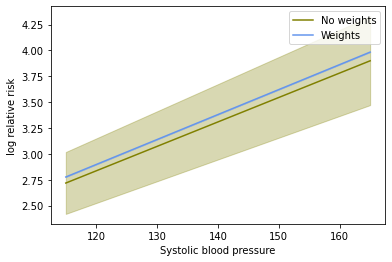

In [31]:
plt.plot(x,slope_fn(beta_s,x),label="No weights",c="olive")
plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
plt.plot(x,slope_fn(beta_s_GL,x),label="Weights",c="cornflowerblue")
plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()